In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap
import pickle
import json
from datetime import datetime

from pred_utils.pred_utils import rmsle_exp, cross_val_split
from data_prep.prepare_data import prepare_data

from configs.columns import essential_columns, macro_cols

import matplotlib.pyplot as plt

shap.initjs()

In [2]:
import seaborn as sns

color = sns.color_palette()
sns.set()

---

In [3]:
train_df = pd.read_csv("./data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'])

y_price = train_df.price_doc

train_df_processed, test_df_processed, Y_log1p = prepare_data(train_df, test_df, macro_df)

with open("./configs/good_features_06.txt", "r") as f:
    not_corr_other_columns = list(map(lambda x: x.replace("\n", ""), f.readlines()))

train_df_for_pred = train_df_processed[["timestamp_year_month"] + essential_columns + not_corr_other_columns + macro_cols]
test_df_for_pred = test_df_processed[["timestamp_year_month"] + essential_columns + not_corr_other_columns + macro_cols]

X = train_df_for_pred.copy()
del X["timestamp_year_month"]

X_test = test_df_for_pred.copy()
del X_test["timestamp_year_month"]

/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
model_name = "xgb_0.81_model_2019_05_04_23_50_4th"
model = pickle.load(open("./trained_models/" + model_name + ".dat", "rb"))

pred_test_log1p = model.predict(X_test)
pred_test = np.expm1(pred_test_log1p)

# pd.DataFrame(model.get_booster().get_score(importance_type='weight'), index=["Importance"]).T.sort_values(
#     "Importance", ascending=False)

---

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


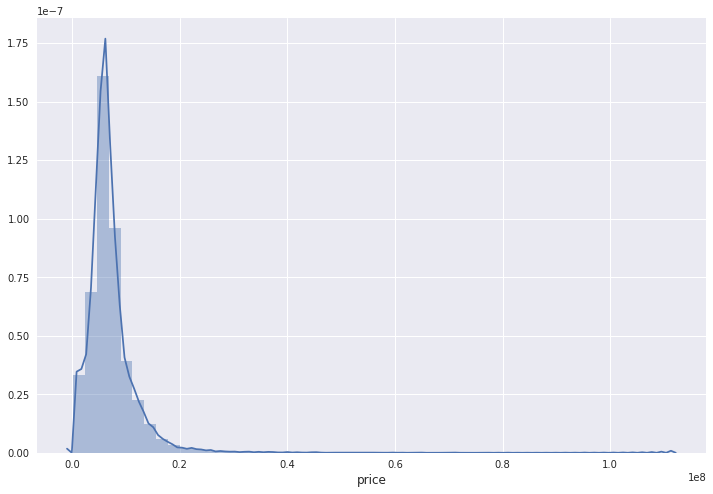

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


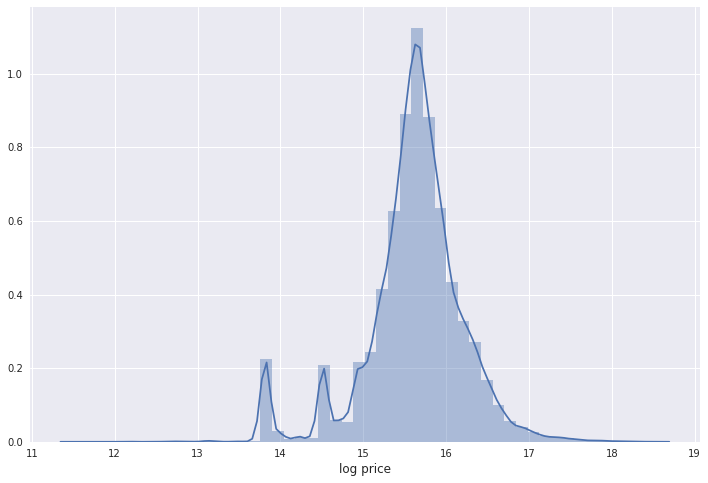

In [5]:
fig = plt.figure(figsize=(12,8))
sns.distplot(y_price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()
fig.savefig("./imgs/features_description/raw_price.png")

fig = plt.figure(figsize=(12,8))
sns.distplot(np.log1p(y_price.values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()
fig.savefig("./imgs/features_description/log_price.png")

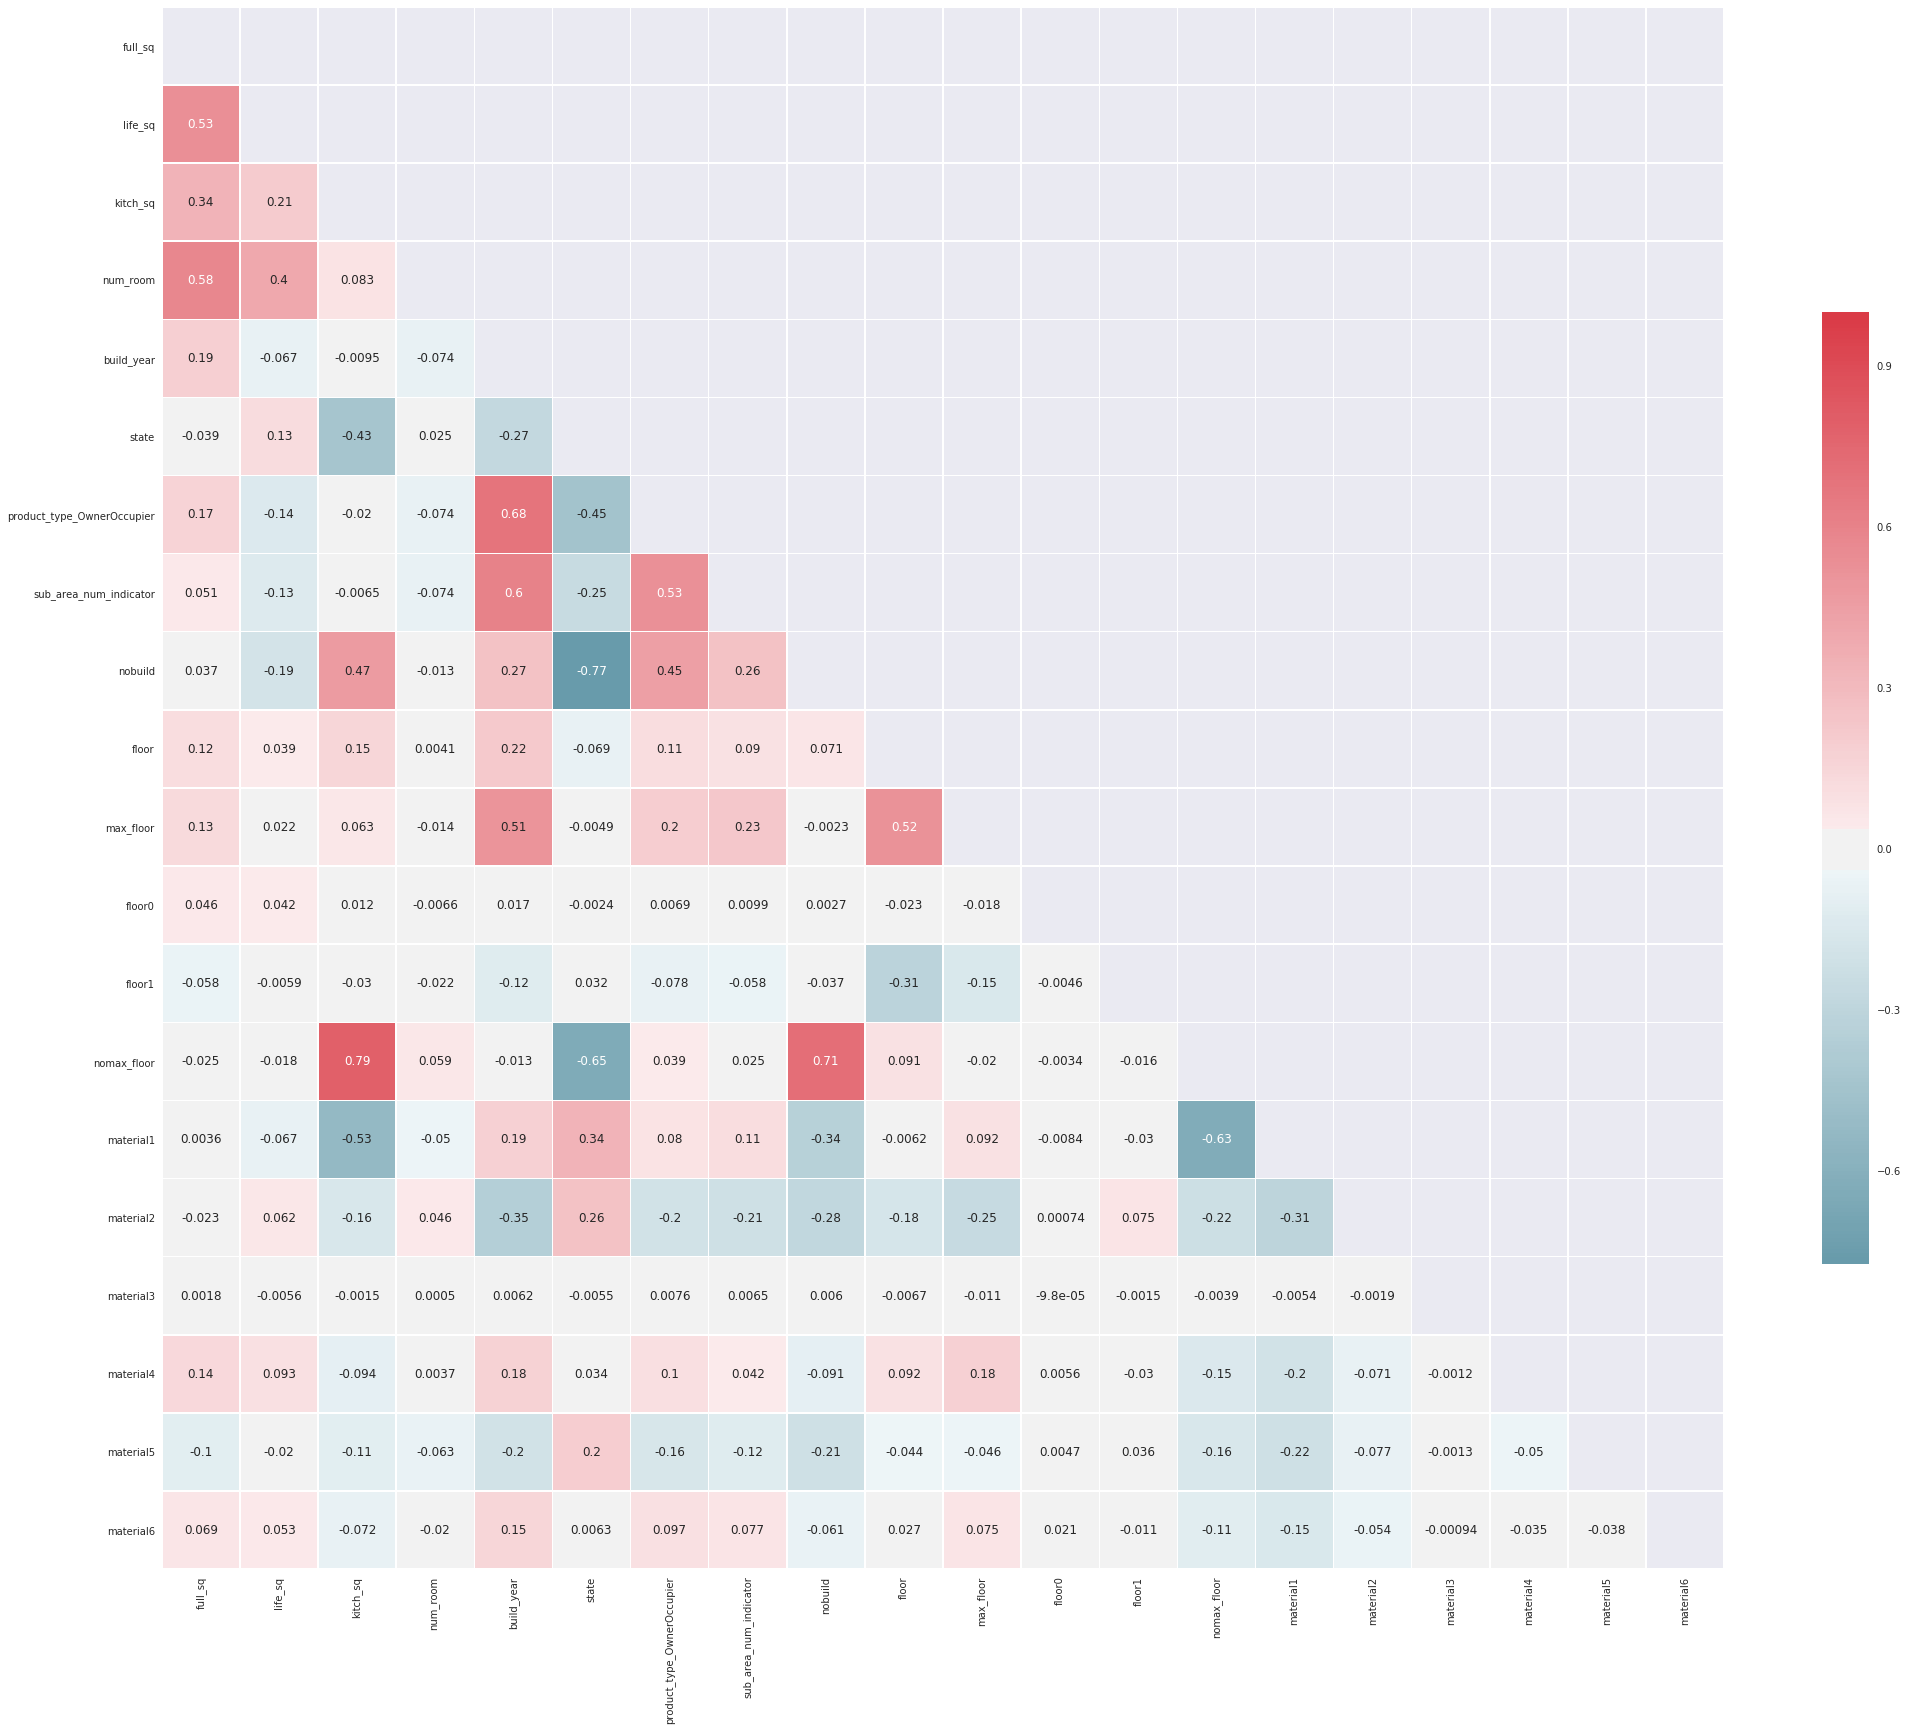

In [6]:
cdf = X[essential_columns].sort_index()
corr_df = cdf.corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(35, 35))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
f.savefig("./imgs/features_description/essential_features_corr.png")

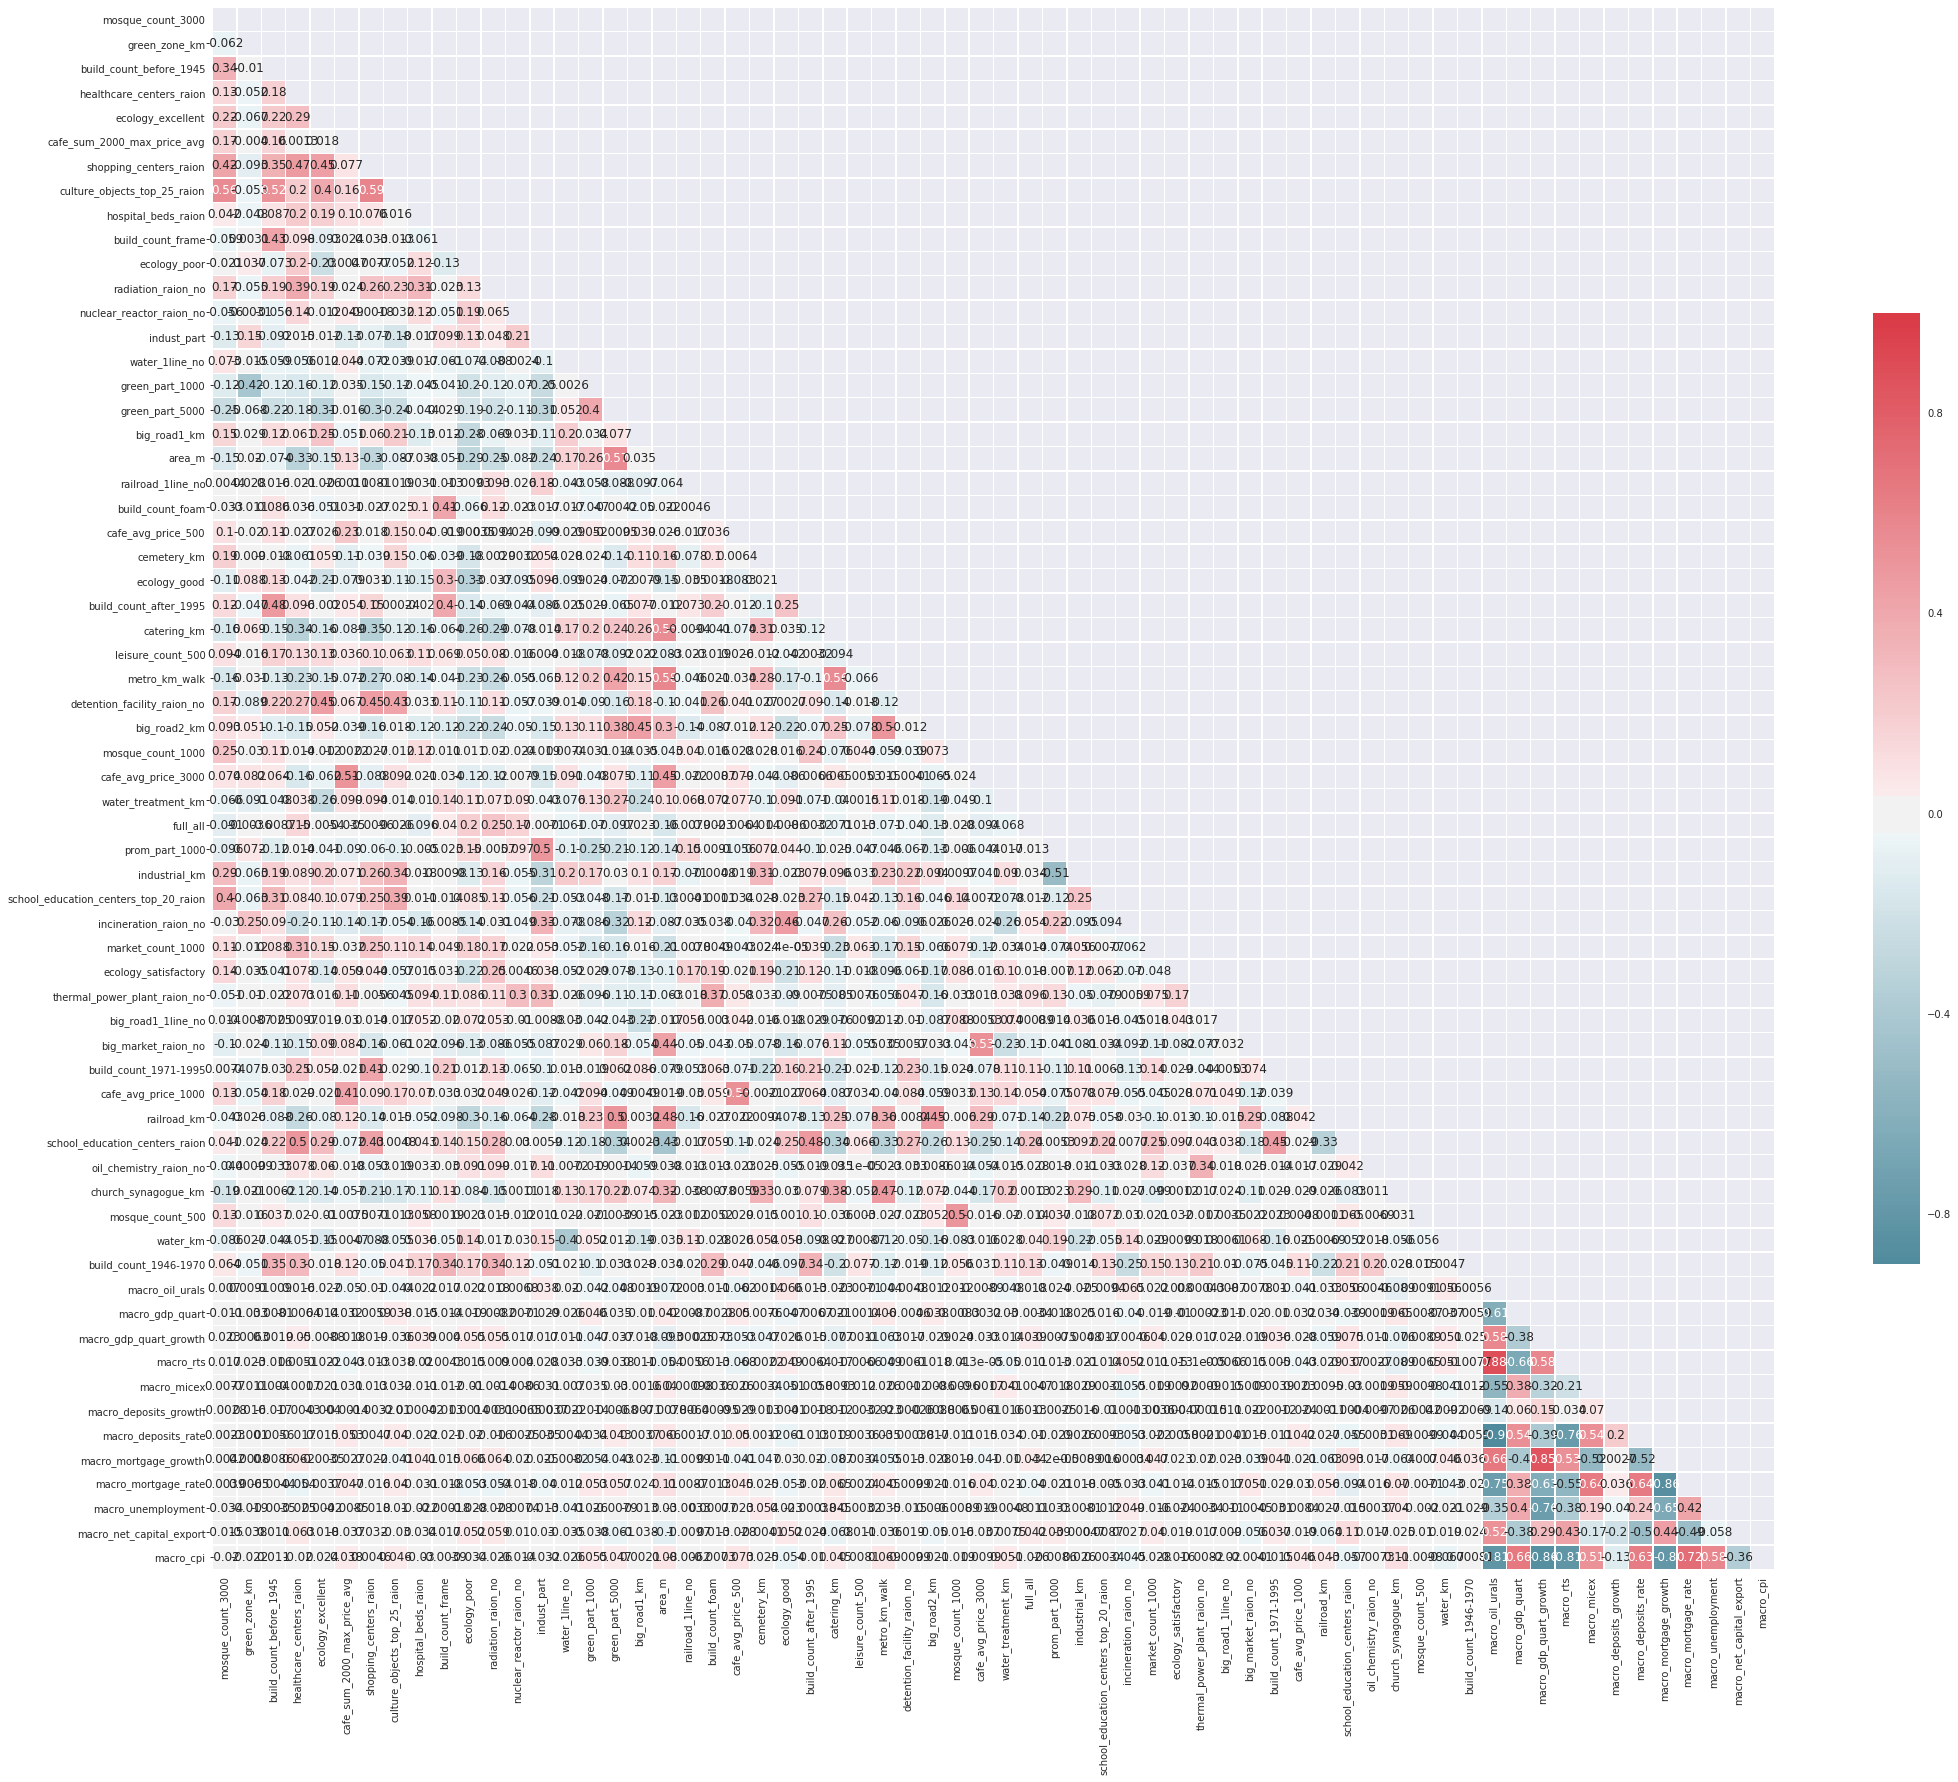

In [7]:
cdf = X[not_corr_other_columns + macro_cols].sort_index()
corr_df = cdf.corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(35, 35))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
f.savefig("./imgs/features_description/other_features_corr.png")

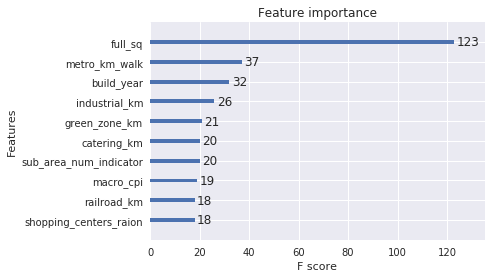

In [8]:
plot_importance(model, max_num_features=10)